### 1. Set Up Environment Variables
To store credentials securely, rename the `.env.sample` file folder to `.env` in the same directory as the notebook and update the variables with the required connection information.

### 2. Install Dependenices


In [1]:
import os
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from azure.core.credentials import AzureKeyCredential
from openai import AzureOpenAI
from azure.search.documents import SearchClient
import dotenv
from azure.search.documents.models import VectorizedQuery, VectorizableTextQuery

dotenv.load_dotenv()

True

### 3. Load environment variables and instantiate your OpenAI and AI Search clients

In [6]:
# Load Azure OpenAI environment variables
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME")
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME")

# Load Azure Search environment variables
AZURE_SEARCH_ENDPOINT = os.getenv("AZURE_SEARCH_ENDPOINT")
AZURE_SEARCH_INDEX_NAME = os.getenv("AZURE_SEARCH_INDEX_NAME")
AZURE_SEARCH_ADMIN_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")

# 🔹 Initialize Azure OpenAI Client (API Key or Managed Identity)
if AZURE_OPENAI_API_KEY:
    openai_client = AzureOpenAI(
        api_key=AZURE_OPENAI_API_KEY,
        azure_endpoint=AZURE_OPENAI_ENDPOINT,
        api_version="2024-10-21"
    )
else:
    azure_credential = DefaultAzureCredential()
    token_provider = get_bearer_token_provider(azure_credential, "https://cognitiveservices.azure.com/.default")
    openai_client = AzureOpenAI(
        azure_ad_token_provider=token_provider,
        azure_endpoint=AZURE_OPENAI_ENDPOINT,
        api_version="2024-10-21"
    )

# 🔹 Initialize Azure AI Search Client (API Key or Managed Identity)
if AZURE_SEARCH_ADMIN_KEY:
    search_client = SearchClient(
        endpoint=AZURE_SEARCH_ENDPOINT,
        index_name=AZURE_SEARCH_INDEX_NAME,
        credential=AzureKeyCredential(AZURE_SEARCH_ADMIN_KEY)
    )
else:
    azure_credential = DefaultAzureCredential()
    search_client = SearchClient(
        endpoint=AZURE_SEARCH_ENDPOINT,
        index_name=AZURE_SEARCH_INDEX_NAME,
        credential=azure_credential
    )

def get_embedding(text):
    return openai_client.embeddings.create(
        model=os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME"),
        input=text
    ).data[0].embedding

In [7]:
#Verify that you use the right endpoints
print(f"Azure OpenAI Endpoint: {AZURE_OPENAI_ENDPOINT}")
print(f"AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME: {AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME}")

Azure OpenAI Endpoint: https://openai-upskilling-gep.openai.azure.com/
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME: text-embedding-ada-002


### 4. Prepare a question

Define a sample question and convert it into an embedding vector:

In [8]:
user_question = "What is included in my Northwind Health Plus plan that is not in standard?"
user_question_vector = get_embedding(user_question)
print(user_question_vector)

[-0.0004826383665204048, -0.007185375317931175, 0.008878480643033981, -0.02254721149802208, -0.032788436859846115, 0.029760116711258888, -0.02271239273250103, -0.024543149396777153, -0.02183142676949501, -0.0006417971453629434, -0.004353208467364311, 0.02228567562997341, -0.031164156273007393, -0.005901780910789967, 0.00643173698335886, -0.0030369223095476627, 0.02262980304658413, -0.007281730882823467, 0.018541572615504265, -0.023731010034680367, -0.0009635560563765466, 0.010743650607764721, 0.018114853650331497, -0.008162696845829487, 0.0016019119648262858, 0.0034670811146497726, 0.0010538893984630704, -0.008761477656662464, -0.013145658187568188, 0.0020355121232569218, 0.04212116450071335, 0.008589413948357105, -0.009773211553692818, -0.023414412513375282, 0.00199077557772398, 0.017550485208630562, 0.0020802486687898636, -0.006097933277487755, 0.02890668250620365, 0.002023467794060707, 0.0241714920848608, 0.004201792646199465, 0.011239193379878998, 0.005423444323241711, -0.000979902

### 5. Retrieve matching documents

Perform a vector search in Azure AI Search to retrieve relevant document chunks:

In [9]:
search_results = search_client.search(
    None,
    top=3,
    vector_queries=[
        VectorizableTextQuery( 
            text=user_question, k_nearest_neighbors=3, fields="text_vector"
        )
    ],
)

# Print Results
for result in search_results:
    print("Chunk ID:", result["chunk_id"])
    print("Title:", result["title"])
    print("Text:", result["chunk"])
    print()

Chunk ID: 7eec7376c470_aHR0cHM6Ly9zYXVwc2tpbGxpbmdnZXAuYmxvYi5jb3JlLndpbmRvd3MubmV0L2hlYWx0aHBsYW4vTm9ydGh3aW5kX0hlYWx0aF9QbHVzX0JlbmVmaXRzX0RldGFpbHMucGRm0_pages_121
Title: Northwind_Health_Plus_Benefits_Details.pdf
Text: their chronic conditions.  



• Be proactive: Talk to your doctor if you have any questions or concerns about your 

condition or care plan.  

At Northwind Health, we understand that managing chronic conditions can be challenging. 

That’s why we’re committed to helping our members get the care and support they need to 

stay healthy and active. Through our Chronic Condition Management Program, we provide 

members with access to an interdisciplinary team of healthcare professionals who can 

provide personalized care and support. We also offer a variety of resources and programs to 

help members manage their chronic conditions. With Northwind Health Plus, you can rest 

assured that you’ll have the support and resources you need to stay healthy and active. 

EXCL

### 6. RAG TIME! Generate a Response

Using the retrieved documents, construct a **system prompt** and generate a response with Azure OpenAI:

In [13]:
# First, let's collect the context from search results
context = ""
for result in search_results:
    context += result["chunk"] + "\n\n"

SYSTEM_MESSAGE = f"""
You are an AI Assistant.
Be brief in your answers. Answer ONLY with the facts listed in the retrieved text.

Context:
{context}
"""

USER_MESSAGE = user_question

response = openai_client.chat.completions.create(
    model=os.getenv("AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME"),
    temperature=0.7,
    messages=[
        {"role": "system", "content": SYSTEM_MESSAGE},
        {"role": "user", "content": USER_MESSAGE},
    ],
)

answer = response.choices[0].message.content
print(answer)




The Northwind Health Plus plan includes expanded coverage for vision care, annual eye exams, and a higher annual reimbursement limit for wellness programs compared to the standard plan.

Token Usage:
Prompt Tokens: 53
Completion Tokens: 33
Total Tokens: 86


### 7. Let's have a look at the metrics
Now that we used the embedding model and the chat completion model, let's have a look at the consumption.
First, let's explore how many tokens the previous answer generation (chat completion) using the RAG pattern required:

In [14]:
print("\nToken Usage of last call:")
print(f"Prompt Tokens: {response.usage.prompt_tokens}")
print(f"Completion Tokens: {response.usage.completion_tokens}")
print(f"Total Tokens: {response.usage.total_tokens}")


Token Usage:
Prompt Tokens: 53
Completion Tokens: 33
Total Tokens: 86


### 8. Challenge
Now let's experiment a little bit with our current RAG setup

#### Task 1
Find out what Healthplans Northwind Health offers in general. Use the same RAG setup as shown above.

In [33]:
user_question = "What Healthplans does Northwind Health offer?"
user_question_vector = get_embedding(user_question)

search_results = search_client.search(
    None,
    top=3,
    vector_queries=[
        VectorizableTextQuery( 
            text=user_question, k_nearest_neighbors=3, fields="text_vector"
        )
    ],
)

context = ""
for result in search_results:
    context += result["chunk"] + "\n\n"

SYSTEM_MESSAGE = f"""
You are an AI Assistant.
Be brief in your answers. Answer ONLY with the facts listed in the retrieved text.

Context:
{context}
"""

USER_MESSAGE = user_question
response = openai_client.chat.completions.create(
    model=os.getenv("AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME"),
    temperature=0.7,
    messages=[
        {"role": "system", "content": SYSTEM_MESSAGE},
        {"role": "user", "content": USER_MESSAGE},
    ],
)

answer = response.choices[0].message.content
print(answer)

NotFoundError: Error code: 404 - {'error': {'code': 'DeploymentNotFound', 'message': 'The API deployment for this resource does not exist. If you created the deployment within the last 5 minutes, please wait a moment and try again.'}}

#### Bonus Task 2:
This is a lot of code to repeat everytime a new questions comes. Create a function that takes the user question as an input and prints out the answer on the screen as a result.

In [24]:
def get_answer_from_question(user_question):
    # Generate embedding for the user question
    user_question_vector = get_embedding(user_question)

    # Perform vector search to retrieve relevant documents
    search_results = search_client.search(
        None,
        top=3,
        vector_queries=[
            VectorizableTextQuery(
                text=user_question, k_nearest_neighbors=3, fields="text_vector"
            )
        ],
    )

    # Collect the context from search results
    context = ""
    for result in search_results:
        context += result["chunk"] + "\n\n"

    # Construct the system message with the retrieved context
    system_message_with_context = f"""
    You are an AI Assistant.
    Be brief in your answers. Answer ONLY with the facts listed in the retrieved text.

    Context:
    {context}
    """

    # Generate a response using Azure OpenAI
    response = openai_client.chat.completions.create(
        model=os.getenv("AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME"),
        temperature=0.7,
        messages=[
            {"role": "system", "content": system_message_with_context},
            {"role": "user", "content": user_question},
        ],
    )

    # Extract and return the answer
    return response.choices[0].message.content

#### Task 3:
Now find the answers to the following questions: Is there a limit on how much can be expensed with PerksPlus?

In [28]:
user_question = "Is there a limit on how much can be expensed with PerksPlus?""
result = get_answer_from_question(user_question)
print(result)

Yes, employees can expense up to $1000 for fitness-related programs under the PerksPlus program.


#### Task 4:
Let's test the system whether it avoids hallucination or answers with irrelevant information when it shouldn't. Think of a question that surely has nothing to do with the content of the Search index and test your systems ability to handle this!

In [32]:
user_question = "Who won the last FIFA World Cup?"
result = get_answer_from_question(user_question)
print(result)

HttpResponseError: () Could not complete vectorization action. Could not reach the vectorization endpoint.
Code: 
Message: Could not complete vectorization action. Could not reach the vectorization endpoint.

#### Task 5:
Find out how many tokens you used up overall for these few questions.
Hint: You can solve this via the Azure Portal

### 9. Let's review the token consumption
Now that we brought a bit more traffic to our models, we can also have a look in Azure AI Foundry to monitor the metrics.

1. Go to the **Overview** page of your Azure OpenAI service in the Azure Portal
2. Click on **Explore Azure AI Foundry portal**
3. A new tab opens and you will land in Azure AI Foundry
4. Go to **Deployments**
5. Select one of the deployed models
6. Select the **Metrics** tab and view the token consumption of that deployment

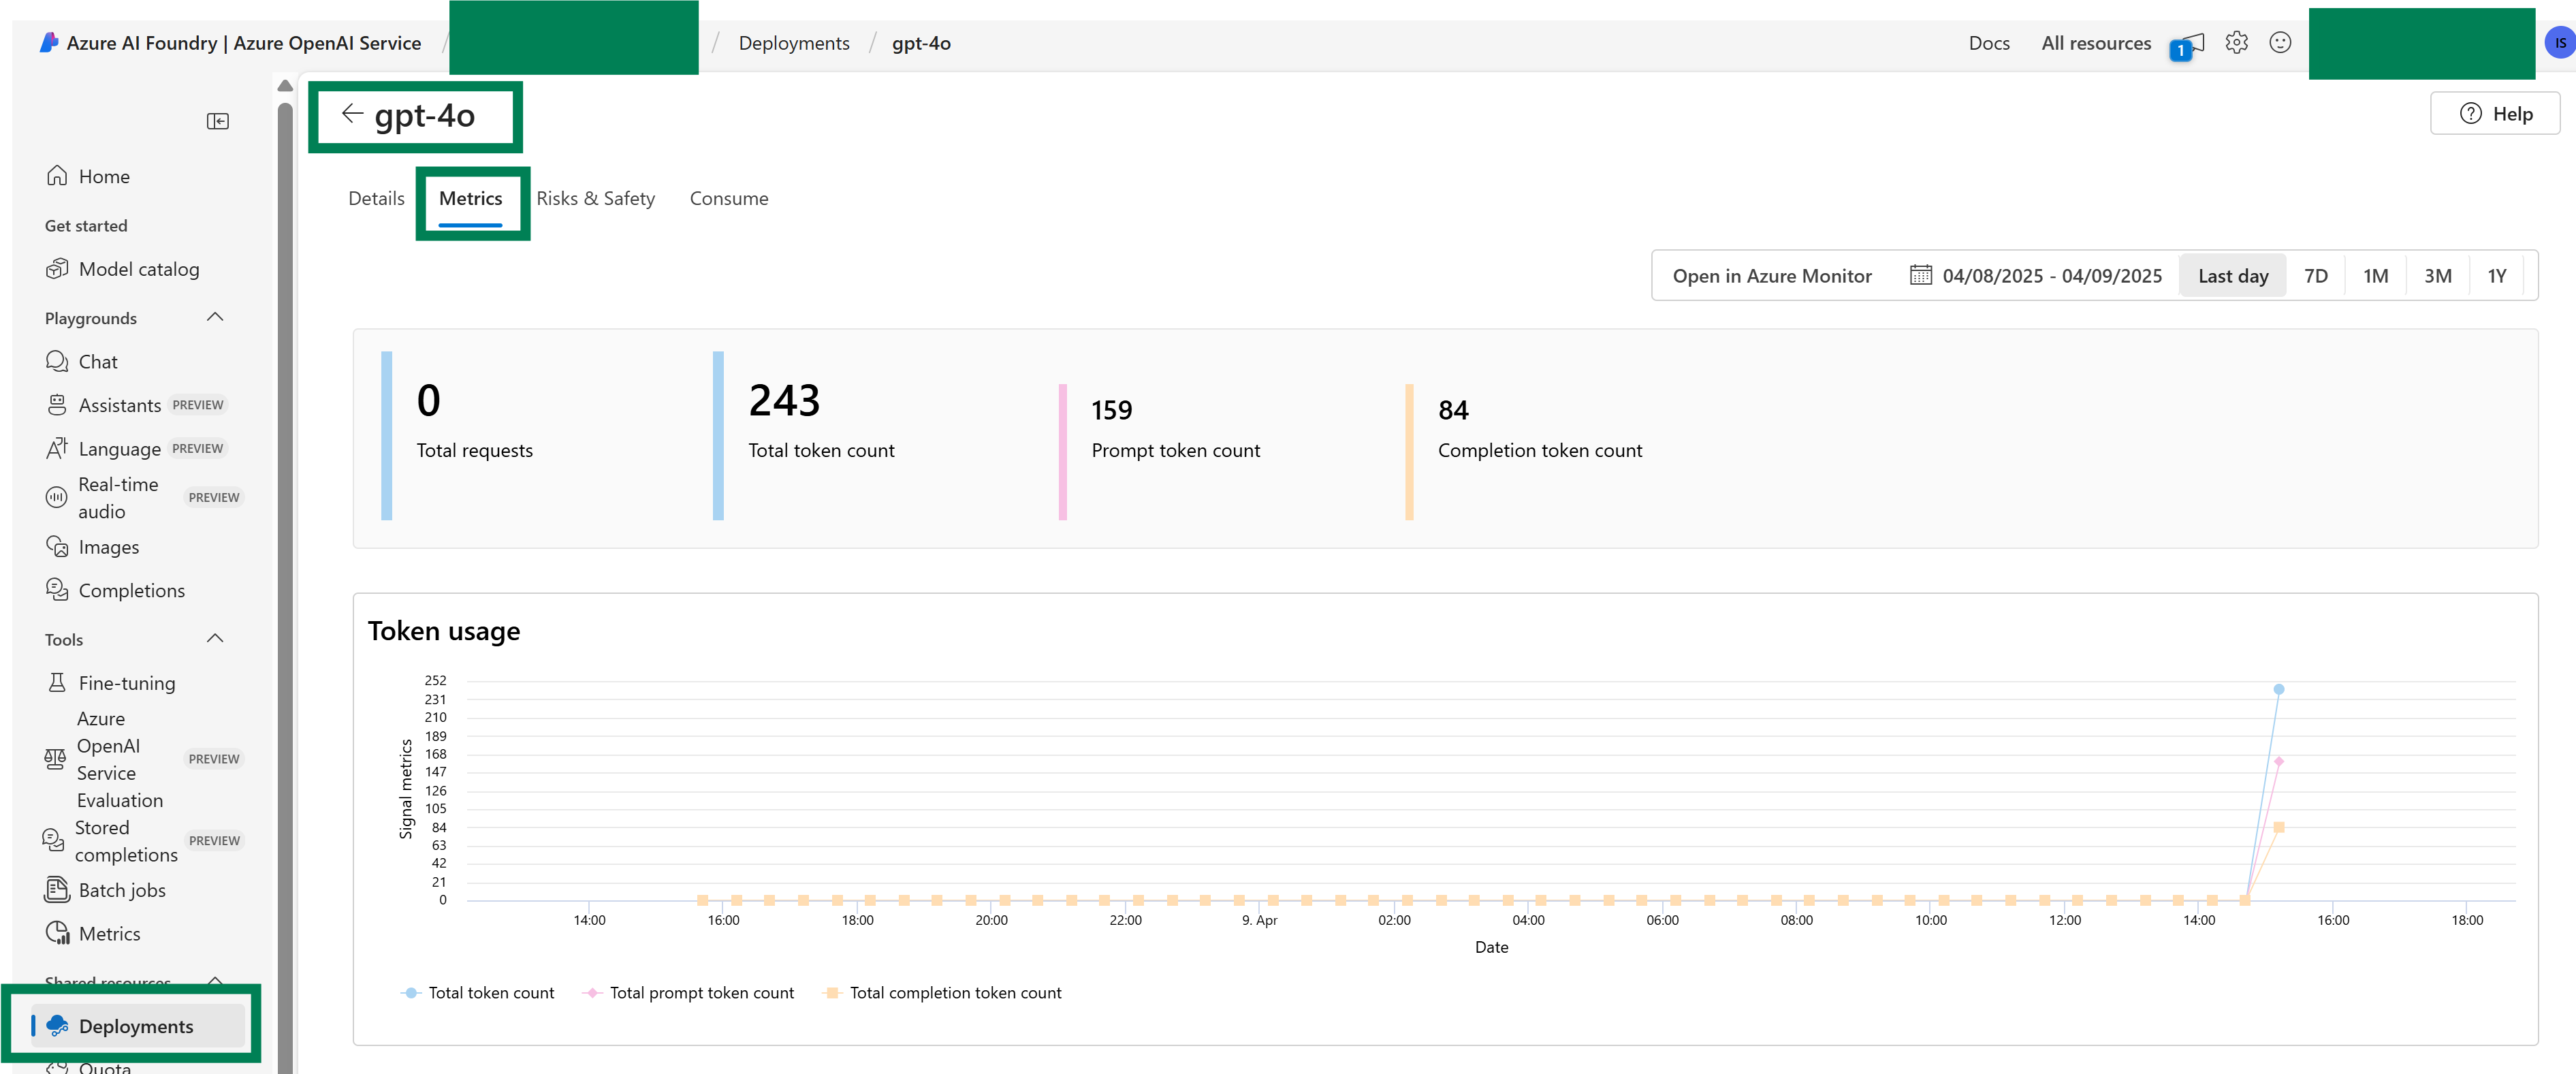

## Troubleshooting

1. **Environment Variables Not Loaded:** Ensure you have correctly set the `.env` file or manually export them in your terminal before running the notebook.
1. **Authentication Issues:** If using Managed Identity, make sure your Azure identity has proper role assignments.
1. **Search Results Are Empty:** Ensure your Azure AI Search index contains vectorized data.
1. **OpenAI API Errors:** Verify your deployment name and API key.

## Summary

This notebook demonstrates a **vector-based RAG pipeline** using Azure OpenAI and Azure AI Search. It retrieves relevant documents using vector search and generates responses using GPT-based chat completions. The approach improves the accuracy of AI responses by grounding them in real data.